In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!tar -xf "/content/drive/My Drive/Projects/SKELY/train.tar.gz"

In [ ]:
# FOR TPU

!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  82500      0 --:--:-- --:--:-- --:--:-- 82500
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
     |████████████████████████████████| 61kB 2.6MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...
- [1 files][108.6 MiB/108.6 MiB]                                                
Operation completed over 1 objects/108.6 MiB.                                    
Copying gs://

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import os
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim

In [ ]:
df = pd.read_csv('/content/training/labels.csv')

In [ ]:
df.head()

,filename,xRot
0,000000.png,182.835227
1,000001.png,246.988824
2,000002.png,280.845321
3,000003.png,261.549108
4,000004.png,192.652170


In [ ]:
df.xRot.describe()

count    9999.000000
mean      160.263950
std        78.621882
min         1.181022
25%        89.672665
50%       159.289332
75%       194.617506
max       359.884274
Name: xRot, dtype: float64

In [ ]:
x = Image.open('/content/training/images/000001.png')

In [ ]:
x.load()

In [ ]:
background = Image.new("RGB", x.size, (255, 255, 255))

In [ ]:
background.paste(x, mask = x.split()[3])

In [ ]:
background.size

(2048, 1898)

In [ ]:
# background

In [ ]:
# backgroud = background.resize((256,256))

In [ ]:
background = background.crop((200, 350 , 1600 , 1850))

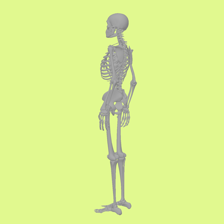

In [ ]:
background.resize((224,224))

In [ ]:
torch.from_numpy(np.array(background)).permute(2,0,1).shape

torch.Size([3, 1400, 800])

In [ ]:
np.array(x).shape

(1898, 2048, 4)

In [ ]:
class Data(Dataset):
    def __init__(self,data_list,data_dir = './',transform=None,train=True):
        super().__init__()
        self.data_list = data_list
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          img_name,target = self.data_list.iloc[item]
        else:
          img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = Image.open(img_path)
        img.load()
        img_rgb = Image.new("RGB", img.size, (255, 255, 255))
        img_rgb.paste(img, mask = img.split()[3])
        img_rgb = img_rgb.crop((200, 350 , 1600 , 1850))
        #change to 224 when using resnet
        img_rgb = img_rgb.resize((64,64))
        # img_rgb = torch.from_numpy(np.array(background)).permute(2,0,1)/255.0
        img_rgb = np.array(img_rgb)/255.0
        if self.transform is not None:
            img_rgb = self.transform(img_rgb)
        if self.train:
          return {
              'gt' : img_rgb,
              'label' : torch.tensor(target)

          }
        else:
          return {
              'gt':img_rgb
          }

In [ ]:
X_ROT = pd.DataFrame()

X_ROT['ImageId'] = df['filename']
X_ROT['target'] = df['xRot']

In [ ]:
target = X_ROT.pop('target')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

X_ROT['target'] = scaler.fit_transform(np.array(target).reshape(-1,1))[:,0]

In [ ]:
X_ROT.head()

,ImageId,target
0,000000.png,0.506419
1,000001.png,0.685268
2,000002.png,0.779654
3,000003.png,0.725859
4,000004.png,0.533787


In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(X_ROT, test_size = 0.2, random_state = 123)  

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))
])

# transforms_train = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor()
# ])
train_path = '/content/training/images'
train_data = Data(data_list= train,data_dir = train_path,
                  transform = transforms_train
                  )

val_data = Data(data_list= val,data_dir = train_path,
                  transform = transforms_train
                  )

In [ ]:
batch = 16
# valid_size = 0.2
# num = train_data.__len__()
# # Dividing the indices for train and cross validation
# indices = list(range(num))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size*num))
# train_idx,valid_idx = indices[split:], indices[:split]

# #Create Samplers
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size = batch, shuffle=True, num_workers=4)
valid_loader = DataLoader(val_data,  batch_size = 4, num_workers=4)

In [ ]:
next(iter(train_loader))['gt'].shape

torch.Size([16, 3, 224, 224])

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print(device)

cuda


In [ ]:
%%capture
! pip install git+https://github.com/PytorchLightning/pytorch-lightning.git@master --upgrade

In [ ]:
import pytorch_lightning as pl

class Network(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 5, stride=1, padding=2)
#         self.norm1= nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3,stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3,stride=1, padding=1)
#         self.norm2= nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv6 = nn.Conv2d(32, 64, 3,stride=1, padding=1)
        self.conv7 = nn.Conv2d(64, 64, 3,stride=1, padding=1)
#         self.norm2= nn.BatchNorm2d(16)
        self.pool3 = nn.MaxPool2d(2,2)
#         self.conv3 = nn.Conv2d(16, 32, 3,stride=1, padding=1)
#         self.norm3= nn.BatchNorm2d(32)
#         self.pool3 = nn.MaxPool2d(2,2)       
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,1)

    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool3(x)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # def __init__(self):
    #     super().__init__()
    #     self.feature_extractor = models.resnet18(pretrained=True)
    #     # Resnet as fixed Feature Extractor
    #     for param in self.feature_extractor.parameters():
    #         param.requires_grad = False
    #     self.feature_extractor.fc = nn.Sequential(nn.Linear(self.feature_extractor.fc.in_features,1024), nn.LeakyReLU(inplace=True), 
    #                                               nn.Linear(1024,1024), nn.LeakyReLU(inplace=True), nn.Linear(1024,512), nn.LeakyReLU(inplace=True), 
    #                                               nn.Linear(512,256), nn.LeakyReLU(inplace=True), nn.Linear(256,1))
    #     # Fine Tuning Resnet
    #     # self.feature_extractor.fc= nn.Linear(self.feature_extractor.fc.in_features,1)
    # def forward(self, x):
    #   # Forward pass
    #     x = self.feature_extractor(x)
    #     #x = F.softmax(x)
    #     return x
    
    
    def train_dataloader(self):
        return DataLoader(train_data, batch_size = batch)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-3)
        schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5, factor = 0.1)
        return [optimizer], [schedular]
    
    def training_step(self, batch, batch_idx):
        data = batch['gt']
        # target = batch['label'].type(torch.DoubleTensor)
        # logits = self(data)[:,0].type(torch.DoubleTensor)
        #TPU
        target = batch['label']
        logits = self(data)[:,0]
        loss = F.mse_loss(logits, target)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}
    
    # def training_epoch_end(self, outputs):
    #     avg_train_loss = torch.stack([x['train_loss'] for x in outputs]).mean()
    #     train_logs = {'train_loss': avg_train_loss}
    #     return {'avg_train_loss':avg_train_loss, 'log':train_logs}
    
    def validation_step(self, batch, batch_idx):
        data = batch['gt']
        # target = batch['label'].type(torch.DoubleTensor)
        # logits = self(data)[:,0].type(torch.DoubleTensor)
        #TPU
        target = batch['label']
        logits = self(data)[:,0]
        loss = F.mse_loss(logits, target)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_logs = {'val_loss': avg_val_loss}
        return {'avg_val_loss':avg_val_loss, 'log':val_logs}
    
    def val_dataloader(self):
        return DataLoader(val_data,  batch_size = 4)

    # def test_step(self, batch, batch_idx):
    #     data = batch['gt'].squeeze(0)
    #     target = batch['label']
    #     logits = self(data)[:,0]
    #     loss = F.mse_loss(logits, target)
    #     return {'val_loss': loss}
    
    # def test_epoch_end(self, outputs):
    #     avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    #     val_logs = {'val_loss': avg_val_loss}
    #     return {'avg_val_loss':avg_val_loss, 'log':val_logs}
    
    # def test_dataloader(self):
    #     return DataLoader(train_data, batch_size = batch, sampler = valid_sampler)

In [ ]:
# model = Network()

In [ ]:
# model(next(iter(train_loader))['gt']).shape

In [ ]:
# from pytorch_lightning import Trainer
# model = Network()
# trainer = Trainer(num_tpu_cores=8)
# lr_finder = trainer.lr_find(model)

# # Results can be found in
# lr_finder.results

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

In [ ]:
from pytorch_lightning import Trainer, seed_everything
seed_everything(0)
# from pytorch_lightning.loggers.neptune import NeptuneLogger
from pytorch_lightning.callbacks import EarlyStopping


model = Network()
# neptune_logger = NeptuneLogger(
#     api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiN2Q5MmEzMDMtNmQzYS00MTdiLTg5YTgtN2I2MGFmMThkODE1In0=",
#     project_name="devesh2707/sandbox",
#     experiment_name="Orientime",
#     close_after_fit=False
# )
# early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4)
trainer = Trainer(max_epochs=5, num_tpu_cores=8)
trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores
training on 8 TPU cores
INIT TPU local core: 0, global rank: 0
INIT TPU local core: 1, global rank: 1
INIT TPU local core: 7, global rank: 7
INIT TPU local core: 4, global rank: 4
INIT TPU local core: 3, global rank: 3
INIT TPU local core: 6, global rank: 6
INIT TPU local core: 2, global rank: 2
INIT TPU local core: 5, global rank: 5

   | Name  | Type      | Params
-------------------------------------
0  | conv1 | Conv2d    | 1 K   
1  | conv2 | Conv2d    | 6 K   
2  | pool1 | MaxPool2d | 0     
3  | conv3 | Conv2d    | 4 K   
4  | conv4 | Conv2d    | 9 K   
5  | pool2 | MaxPool2d | 0     
6  | conv6 | Conv2d    | 18 K  
7  | conv7 | Conv2d    | 36 K  
8  | pool3 | MaxPool2d | 0     
9  | fc1   | Linear    | 2 M   
10 | fc2   | Linear    | 262 K 
11 | fc3   | Linear    | 513   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:22: UserWarning: cleaning up... please do not interrupt
  warnings.warn(*args, **kwargs)


1

In [ ]:
!tar -xf "/content/drive/My Drive/Projects/SKELY/test.tar.gz"

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Projects/SKELY/sample_submission.csv')

In [ ]:
test.head()

,filename,xRot
0,009999.png,187.513045
1,010000.png,36.193195
2,010001.png,168.197639
3,010002.png,62.259594
4,010003.png,126.537186


In [ ]:
cols = ['ImageID', 'target']

test.columns = cols

In [ ]:
test.head()

,ImageID,target
0,009999.png,187.513045
1,010000.png,36.193195
2,010001.png,168.197639
3,010002.png,62.259594
4,010003.png,126.537186


In [ ]:
test_path = '/content/images'
test_data = Data(data_list= test,data_dir = test_path,
                  transform = transforms_train
                  )

In [ ]:
test_loader = DataLoader(test_data, batch_size = 1, shuffle=False)

In [ ]:
import torch_xla as xla
import torch_xla.core.xla_model as xm

In [ ]:
device=xm.xla_device()

In [ ]:
model = model.to(device)

In [ ]:
out = model(next(iter(test_loader))['gt'].to(device))

In [ ]:
out.item()

-0.34038352966308594

In [ ]:
model.eval()
preds = []
i = 0
with torch.no_grad():
    for batch in test_loader:
        i += 1
        if i % 1000 == 0:
          print(i)
        data = batch['gt'].to(device)
        outputs = model(data)
        pred = outputs.cpu()
        preds.append(pred.item())

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [ ]:
preds = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

In [ ]:
sub = pd.read_csv('/content/drive/My Drive/Projects/SKELY/sample_submission.csv')

In [ ]:
sub['xRot'] = preds

In [ ]:
sub.to_csv("resnet_18.csv", index = False)